In [4]:
import pandas as pd
import numpy as np
import torch.nn as nn
import sklearn
#from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
pd.set_option('display.max_columns', None)
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import multiprocessing
import scipy
from sklearn.model_selection import KFold

# 读取数据

In [5]:
x_data = pd.read_excel("All features.xlsx")
x_data

,c1nc[nH]n1,c1c[nH]cn1,c1cc[nH]c1,c1ccncc1,c1ccc2[nH]ccc2c1,c1ccc2scnc2c1,c1ccc2cc3ccccc3cc2c1,c1cscn1,c1ccsc1,c1cn[nH]c1,c1ccc2occcc2c1,c1cc2ccc(ccnccc3ccc(ccn1)[nH]3)[nH]2,c1ccccc1,c1nnn[nH]1,c1ccc2sc[n+]c2c1,c1ccc2ncccc2c1,c1nncs1,Alkene,Alkylchloride,Alkylfluoride,Alkylbromide,Trifluoromethyl,Alcohol,Althoxyl,Primary_aliph_amine,Secondary_aliph_amine,Tertiary_aliph_amine,Primary_arom_amine,Secondary_arom_amine,Tertiary_arom_amine,Alkylthiol,Dialkylthioether,Disulfide,Aldehyde,Ketone,Oxime,Acetal,Hemiacetal,Thioacetal,Chloroalkene,Bromoalkene,Enol,Carboxylic_acid,Carboxylic_ester,Lactone,Amide,Lactam,Nitrile,Thiourea,Phenol,Arylchloride,Arylfluoride,Arylbromide,Aryliodide,Arylthiol,Oxoarene,Azo,Nitro,Sulfon,Sulfonic_derivative,Phosphonic_acid_derivative,Tri_boron,Sugar_pattern_combi,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,Kappa1,Kappa2,Kappa3,LabuteASA,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,TPSA,EState_VSA1,EState_VSA10,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,VSA_EState1,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,FractionCSP3,HeavyAtomCount,NHOHCount,NOCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticCarbocycles,NumAromaticHeterocycles,NumAromaticRings,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,RingCount,MolLogP,MolMR,Num of Conju-Strut,Num of Conju-All-Atoms,Atom Num Conju-All Ratio,AtomWt Conju-All Ratio,Full-Mol Wiener Index,Individual Conju-Atom Number (Max-Conju),Conju-Part-Wt (Max-Conju),Conju-AtomicWt (Max-Conju),Max Conju-Distance (Max-Conju),Conju-Branch Index (Max-Conju),Conju-Strut Wiener Index (Max-Conju),Atom_PEOE-Charge_Sum,Atom_LogP_Sum,Atom_MR_Sum,Atom_PEOE-Charge_Mean,Atom_LogP_Mean,Atom_MR_Mean,Atom_PEOE-Charge_Std,Atom_LogP_Std,Atom_MR_Std,Atom_PEOE-Charge_Max,Atom_LogP_Max,Atom_MR_Max,Atom_PEOE-Charge_Min,Atom_LogP_Min,Atom_MR_Min,Atom_PEOE-Charge_Delta,Atom_LogP_Delta,Atom_MR_Delta,Fun_PEOE-Charge_Sum,Fun_LogP_Sum,Fun_MR_Sum,Fun_PEOE-Charge_Mean,Fun_LogP_Mean,Fun_MR_Mean,Fun_PEOE-Charge_Std,Fun_LogP_Std,Fun_MR_Std,Fun_PEOE-Charge_Max,Fun_LogP_Max,Fun_MR_Max,Fun_PEOE-Charge_Min,Fun_LogP_Min,Fun_MR_Min,Fun_PEOE-Charge_Delta,Fun_LogP_Delta,Fun_MR_Delta,Mid-Fun_PEOE-Charge_Sum,Mid-Fun_LogP_Sum,Mid-Fun_MR_Sum,Mid-Fun_PEOE-Charge_Mean,Mid-Fun_LogP_Mean,Mid-Fun_MR_Mean,Mid-Fun_PEOE-Charge_Std,Mid-Fun_LogP_Std,Mid-Fun_MR_Std,Mid-Fun_PEOE-Charge_Max,Mid-Fun_LogP_Max,Mid-Fun_MR_Max,Mid-Fun_PEOE-Charge_Min,Mid-Fun_LogP_Min,Mid-Fun_MR_Min,Mid-Fun_PEOE-Charge_Delta,Mid-Fun_LogP_Delta,Mid-Fun_MR_Delta,Conju_PEOE-Charge_Sum,Conju_LogP_Sum,Conju_MR_Sum,Conju_PEOE-Charge_Mean,Conju_LogP_Mean,Conju_MR_Mean,Conju_PEOE-Charge_Std,Conju_LogP_Std,Conju_MR_Std,Conju_PEOE-Charge_Max,Conju_LogP_Max,Conju_MR_Max,Conju_PEOE-Charge_Min,Conju_LogP_Min,Conju_MR_Min,Conju_PEOE-Charge_Delta,Conju_LogP_Delta,Conju_MR_Delta,Atom Number,Occupied Orbitals,Molecule Weight,HOMO,LUMO,HOMO-LUMO Gap,Farthest Distance,Molecular Radius,Molecular Size Short,Molecular Size Medium,Molecular Size Long,Long/Sum Size Ratio,Length/Diameter,MPP,SDP,Dipole Moment (a.u.),Quadrupole Moment,Octopole Moment,ODI LUMO+1,ODI LUMO,ODI HOMO,ODI HOMO-1,ODI Mean,ODI Std,Isosurface area,Sphericity,Volume (Angstrom^3),Density (g/cm^3),LEAE Minimal Value,LEAE Maximal Value,Surfac

In [6]:
y_data = pd.read_csv("Target.csv", usecols=[2])
y_data

,FEaverage CH4
0,5.825667
1,8.633013
2,3.251174
3,7.140325
4,4.555200
...,...
77,8.777520
78,5.726452
79,7.069215
80,11.296992


In [7]:
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
x_data.columns = [regex.sub("_", col) if any(i in str(col) for i in set(('[', ']', '<'))) 
                        else col for col in x_data.columns.values]

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=0.8, random_state=0)

In [8]:
scaler1 = preprocessing.MinMaxScaler().fit(x_train)  # 通过训练集获得归一化函数模型，使用 x_train 数据来计算缩放器需要的最小值和最大值
scaler2 = preprocessing.MinMaxScaler().fit(y_train)

x_train = scaler1.transform(x_train)#使用拟合好的缩放器对 x_train 数据进行缩放
x_test = scaler1.transform(x_test)

y_train = scaler2.transform(y_train)
y_test = scaler2.transform(y_test)

In [9]:
num_cores = multiprocessing.cpu_count()

In [8]:
kf = KFold(n_splits=10, random_state=0, shuffle=True) # 5折交叉验证
#mse它测量的是预测值与实际值之间差值的平方的平均值。均方误差越小，模型的预测性能越好
variate=list(range(x_train.shape[1]))   #变量索引列表
selected=[]   #变量索引
train_mse_list = []
val_mse_list = []

current_score,best_new_score=float('inf'),float('inf')  
#验证集目前的分数和最好分数初始值都为无穷大（因为mse越小越好）
    
# def my_custom_loss_func(y, y_predict):
#     error = 0
#     for i in range(0, y.shape[1]):
#         error += mean_squared_error(y[:, i], y_predict[:, i])
#     error = error / y.shape[1]
#     return error

# my_scorer = make_scorer(my_custom_loss_func, greater_is_better=False)

#循环筛选变量
while variate:
    mse_with_variate_train = []
    mse_with_variate_val=[]
    for i in variate:  #逐个遍历自变量
        current_variate = selected+[i]   #当前变量
        current_x_train = x_train[:, current_variate]   #当前x_train
        current_x_test = x_test[:, current_variate]   #当前x_test
        
        train_mse_list_ = []
        val_mse_list_ = []
        
        for train_index, val_index in kf.split(current_x_train, y_train):
            x_train_ = current_x_train[train_index, :]
            x_val_ = current_x_train[val_index, :]
            y_train_ = y_train[train_index, :]
            y_val_ = y_train[val_index, :]
            
            #model = MLPRegressor(random_state=0,early_stopping=True,alpha=0.0001,hidden_layer_sizes=(1,),learning_rate_init=0.01,
            #                    max_iter=5000,n_iter_no_change=100)
            svr = SVR(kernel='rbf')
            multioutput_svr = MultiOutputRegressor(svr, n_jobs=-1)
            multioutput_svr.fit(x_train_, y_train_)
        
            train_pre = multioutput_svr.predict(x_train_)
            val_pre = multioutput_svr.predict(x_val_)
            
            train_mse_ = mean_squared_error(y_train_, train_pre)
    
            val_mse_ = mean_squared_error(y_val_, val_pre)
    
            train_mse_list_.append(train_mse_)
    
            val_mse_list_.append(val_mse_)
            
        train_mse = np.mean(train_mse_list_)
        
        val_mse = np.mean(val_mse_list_)
        
        mse_with_variate_train.append((train_mse,i))
        
        mse_with_variate_val.append((val_mse,i))
            
    min_mse_index = mse_with_variate_val.index(min(mse_with_variate_val))
    best_new_score,best_candidate_index = mse_with_variate_val[min_mse_index]
    train_new_score,_ = mse_with_variate_train[min_mse_index]
        
    variate.remove(best_candidate_index)  #移除加进来的变量名，即第二次循环时，不考虑此自变量了
    selected.append(best_candidate_index)  #将此自变量作为加进模型中的自变量
    
    train_mse_list.append(mse_with_variate_train[min_mse_index][0])
    
    val_mse_list.append(mse_with_variate_val[min_mse_index][0])
        
        #if current_score>best_new_score:
            #variate.remove(best_candidate_index)  #移除加进来的变量名，即第二次循环时，不考虑此自变量了
            #selected.append(best_candidate_index)  #将此自变量作为加进模型中的自变量
            #current_score = best_new_score  #最新的分数等于最好的分数
            #print("score is {},continuing!".format(current_score))  #输出最小的mse值
        #else:
            #print("for selection over!")
            #break

In [10]:
selected

[188,
 136,
 302,
 306,
 204,
 155,
 263,
 146,
 153,
 3,
 61,
 95,
 163,
 112,
 50,
 124,
 160,
 258,
 303,
 213,
 123,
 126,
 29,
 19,
 22,
 165,
 262,
 249,
 240,
 0,
 1,
 14,
 2,
 180,
 17,
 255,
 109,
 113,
 45,
 28,
 21,
 116,
 4,
 6,
 9,
 11,
 13,
 259,
 15,
 16,
 18,
 20,
 26,
 33,
 35,
 36,
 37,
 39,
 40,
 41,
 43,
 47,
 53,
 56,
 60,
 62,
 110,
 183,
 23,
 242,
 118,
 251,
 10,
 134,
 241,
 250,
 44,
 55,
 130,
 139,
 216,
 222,
 231,
 225,
 59,
 34,
 97,
 198,
 91,
 49,
 162,
 268,
 25,
 294,
 46,
 144,
 141,
 99,
 269,
 57,
 108,
 161,
 58,
 193,
 51,
 234,
 295,
 187,
 275,
 208,
 147,
 196,
 185,
 284,
 42,
 137,
 135,
 66,
 169,
 243,
 131,
 237,
 246,
 83,
 201,
 129,
 87,
 119,
 167,
 8,
 293,
 73,
 219,
 181,
 207,
 192,
 202,
 72,
 84,
 195,
 190,
 121,
 189,
 71,
 148,
 92,
 299,
 96,
 228,
 75,
 106,
 290,
 186,
 296,
 152,
 252,
 120,
 291,
 282,
 277,
 217,
 235,
 285,
 247,
 244,
 238,
 210,
 115,
 31,
 281,
 157,
 145,
 177,
 100,
 220,
 276,
 199,
 81,
 194,
 

In [11]:
train_mse_list

[0.03295821474632253,
 0.02296670314595512,
 0.01618747355537318,
 0.014022365724047709,
 0.011209055904970453,
 0.011988735893148266,
 0.009921884210260846,
 0.00970537181266629,
 0.011121546193730996,
 0.011873590546288703,
 0.012735259655858385,
 0.012279944841486864,
 0.012900262216078895,
 0.01241525356440932,
 0.012629137863306392,
 0.012301042023663394,
 0.011833101731442,
 0.011521424071695674,
 0.011739298842157617,
 0.011476271185563377,
 0.010944152186085628,
 0.011235772648795913,
 0.011307228001134617,
 0.01124397822835423,
 0.011381954352962857,
 0.011436885363927696,
 0.011333092677095754,
 0.011488098237545675,
 0.011621677189770056,
 0.01170167385806661,
 0.011777229326285134,
 0.011890401212154478,
 0.0119544891351146,
 0.012015494392793322,
 0.011995024258092546,
 0.012466519848062357,
 0.011234172705935535,
 0.011076505553315904,
 0.011100235470840065,
 0.011113907581815836,
 0.011145016848186164,
 0.010927969597278517,
 0.01097221312596346,
 0.011018184355809998,
 

In [12]:
val_mse_list

[0.04273834472735134,
 0.037112647432651406,
 0.0319459992767449,
 0.029454105351851983,
 0.028418701512945947,
 0.02832230417760659,
 0.026208441843107506,
 0.025463030615704763,
 0.026016731845236563,
 0.026432543196113916,
 0.026599297839198337,
 0.026654303492190074,
 0.026997332167525073,
 0.027576271951461263,
 0.027014675752240275,
 0.026534011043830703,
 0.026207847192318535,
 0.024869363089871047,
 0.024643974575573376,
 0.02416616739735423,
 0.024152967931403837,
 0.02409936651272624,
 0.024088741415587145,
 0.024105469697621035,
 0.02417779715127282,
 0.0241520377794309,
 0.02411768624697748,
 0.024153149091028826,
 0.02417494088876046,
 0.02423023951336944,
 0.024316377423447506,
 0.024417177949175455,
 0.024494177783825725,
 0.024555444928920086,
 0.024634209798908402,
 0.024605539642601378,
 0.0242026401348565,
 0.024050553389760542,
 0.024018738984032954,
 0.023977821333712047,
 0.023970160974402632,
 0.023985520528573247,
 0.024008911374544868,
 0.024045117161197636,
 0

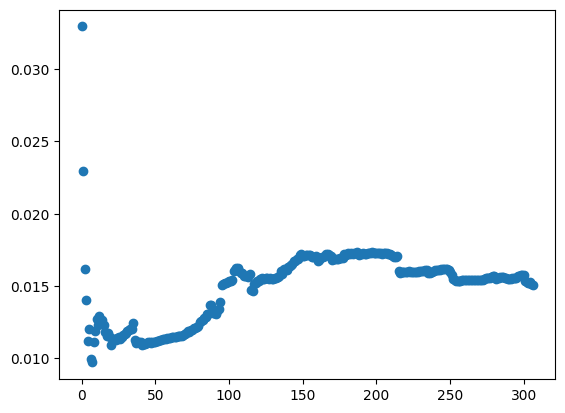

In [13]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

plt.scatter(range(len(train_mse_list)), train_mse_list)
plt.show()

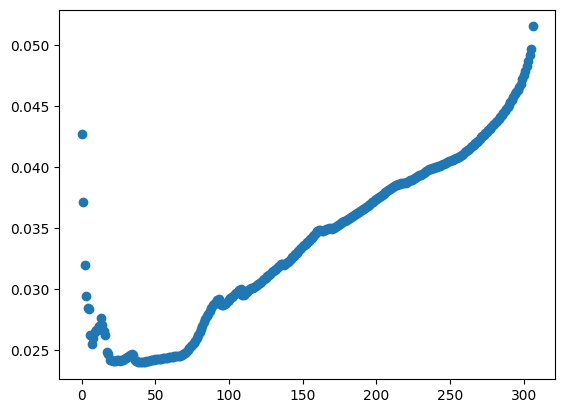

In [14]:
plt.scatter(range(len(val_mse_list)), val_mse_list)
plt.show()

In [10]:

min_index  = val_mse_list.index(min(val_mse_list))
min_value = val_mse_list[min_index]
print(min_index)
print(min_value)

40
0.023970160974402632


In [12]:
selected_columns = x_data.columns[selected[:min_index+1]].tolist()
for col in selected_columns:
    print(col)

Atom_MR_Std
EState_VSA7
Atom1_ESP All average (kcal/mol)
Iaverage / mA cm-2
Fun_PEOE-Charge_Std
NumAliphaticRings
Long/Sum Size Ratio
VSA_EState7
NumAliphaticCarbocycles
c1ccncc1
Tri_boron
PEOE_VSA10
NumSaturatedCarbocycles
SMR_VSA4
Arylchloride
SlogP_VSA5
NumHDonors
Farthest Distance
Atom1_ESP Pi (kcal/mol)
Fun_PEOE-Charge_Delta
SlogP_VSA4
SlogP_VSA7
Tertiary_arom_amine
Alkylfluoride
Alcohol
NumSaturatedRings
Molecular Size Long
Conju_PEOE-Charge_Delta
Conju_PEOE-Charge_Std
c1nc_nH_n1
c1c_nH_cn1
c1ccc2sc_n+_c2c1
c1cc_nH_c1
Atom_PEOE-Charge_Sum
Alkene
HOMO
SMR_VSA10
SMR_VSA5
Amide
Secondary_arom_amine
Trifluoromethyl


In [13]:
#col_index = [sorted_index[i] for i in selected[:min_index+1]]
# 指定图像保存的路径
import os
save_dir = '逐步回归S-体系挑选变量\用师兄的特征 and 汪老师的特征'
os.makedirs(save_dir, exist_ok=True)  # 创建目录，如果目录不存在
data = x_data[selected_columns]
# 将选定的数据保存为 CSV 文件
output_file = os.path.join(save_dir, "selected_features-CH4.csv")
data.to_csv(output_file, index=False, encoding='utf_8_sig')
data

,Atom_MR_Std,EState_VSA7,Atom1_ESP All average (kcal/mol),Iaverage / mA cm-2,Fun_PEOE-Charge_Std,NumAliphaticRings,Long/Sum Size Ratio,VSA_EState7,NumAliphaticCarbocycles,c1ccncc1,Tri_boron,PEOE_VSA10,NumSaturatedCarbocycles,SMR_VSA4,Arylchloride,SlogP_VSA5,NumHDonors,Farthest Distance,Atom1_ESP Pi (kcal/mol),Fun_PEOE-Charge_Delta,SlogP_VSA4,SlogP_VSA7,Tertiary_arom_amine,Alkylfluoride,Alcohol,NumSaturatedRings,Molecular Size Long,Conju_PEOE-Charge_Delta,Conju_PEOE-Charge_Std,c1nc_nH_n1,c1c_nH_cn1,c1ccc2sc_n+_c2c1,c1cc_nH_c1,Atom_PEOE-Charge_Sum,Alkene,HOMO,SMR_VSA10,SMR_VSA5,Amide,Secondary_arom_amine,Trifluoromethyl
0,1.869340,0.000000,39.01412,142.333333,2.694263e-01,0,0.491618,0.000000,0,0,1,0.0,0,0.0,0,16.595422,2,8.294,13.207422,6.230093e-01,0.0,0.0,0,0,0,0,10.674,0.000000e+00,0.000000e+00,0,0,0,0,1.670000e-16,0,-0.256346,29.014922,6.923737,0,0,0
1,2.531568,17.512797,20.66318,133.000000,3.895180e-02,0,0.449793,0.000000,0,0,0,0.0,0,0.0,0,0.000000,0,5.355,12.774025,7.790360e-02,0.0,0.0,0,0,0,0,8.372,0.000000e+00,0.000000e+00,0,0,0,0,-4.160000e-17,0,-0.237867,27.266730,0.000000,0,0,0
2,2.287209,0.000000,24.20452,134.666667,2.922371e-02,0,0.399801,0.000000,0,0,0,0.0,0,0.0,0,0.000000,2,4.083,14.830128,5.844742e-02,0.0,0.0,0,0,0,0,7.242,0.000000e+00,0.000000e+00,0,0,0,0,2.780000e-17,0,-0.263323,18.598094,0.000000,0,0,0
3,2.119858,0.000000,21.85000,107.333333,2.517009e-02,0,0.483168,0.259401,0,0,0,0.0,0,0.0,0,12.841643,2,9.190,15.026383,5.339382e-02,0.0,0.0,0,0,0,0,12.214,0.000000e+00,0.000000e+00,0,0,0,0,-2.220000e-16,0,-0.240901,33.526407,12.841643,0,0,0
4,1.708609,23.913925,-10.74523,88.000000,1.040000e-17,0,0.527381,3.793981,0,0,0,0.0,0,0.0,0,0.000000,0,9.166,14.378481,2.080000e-17,0.0,0.0,0,0,0,0,11.566,2.080000e-17,1.040000e-17,0,0,0,0,6.940000e-18,2,-0.226450,11.761885,0.000000,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,1.570519,0.000000,-8.02671,85.333333,0.000000e+00,0,0.660614,10.967467,0,0,0,0.0,0,0.0,0,51.366573,2,15.453,13.985197,0.000000e+00,0.0,0.0,0,0,0,0,18.445,0.000000e+00,0.000000e+00,0,0,0,0,-2.780000e-17,0,-0.239577,25.257578,51.366573,0,0,0
78,1.691556,0.000000,-7.49396,108.333333,0.000000e+00,0,0.625620,8.044435,0,0,0,0.0,0,0.0,0,38.524930,2,12.895,14.029267,0.000000e+00,0.0,0.0,0,0,0,0,15.882,0.000000e+00,0.000000e+00,0,0,0,0,-5.550000e-17,0,-0.239609,25.257578,38.524930,0,0,0
79,1.965093,0.000000,-5.85622,83.666667,0.000000e+00,0,0.569067,3.764228,0,0,0,0.0,0,0.0,0,19.262465,2,9.099,14.192581,0.000000e+00,0.0,0.0,0,0,0,0,12.050,0.000000e+00,0.000000e+00,0,0,0,0,1.110000e-16,0,-0.239940,25.257578,19.262465,0,0,0
80,2.098800,0.000000,-4.26869,97.666667,0.000000e+00,0,0.530080,2.402006,0,0,0,0.0,0,0.0,0,12.841643,2,7.776,14.306475,0.000000e+00,0.0,0.0,0,0,0,0,10.732,0.000000e+00,0.000000e+00,0,0,0,0,-1.670000e-16,0,-0.240430,25.257578,12.841643,0,0,0


In [15]:

from sklearn.metrics import mean_squared_error, r2_score
# 用选出来的最佳变量在测试集上进行评估
min_val_mse_index=min_index
final_x_train = x_train[:, selected[:min_val_mse_index+1]]
final_x_test = x_test[:, selected[:min_val_mse_index+1]]

svr = SVR(kernel='rbf')
multioutput_svr = MultiOutputRegressor(svr, n_jobs=-1)
multioutput_svr.fit(final_x_train, y_train)

test_pred = multioutput_svr.predict(final_x_test)
test_mse = mean_squared_error(y_test, test_pred)
test_r2 = r2_score(y_test, test_pred)
# 保留两位小数
test_mse = round(test_mse, 4)
test_r2 = round(test_r2, 4)

print(f"Selected variables based on validation MSE: {selected_columns}")
print(f"Test MSE: {test_mse}")
print(f"Test R2: {test_r2}")
# 创建保存目录
import os
save_dir = 'Test mse after svr'
os.makedirs(save_dir, exist_ok=True)  # 创建目录，如果目录不存在
output_file1 = os.path.join(save_dir, "final_evaluation-CH4.csv")
# 保存测试集评估结果到CSV
df_summary = pd.DataFrame({
    'Selected Variables': [selected_columns],
    'Final Test MSE': [test_mse],
    'Final Test R2': [test_r2]
})
df_summary.to_csv(output_file1, index=False)

print(f"Results saved to '{output_file1}'")

Selected variables based on validation MSE: ['Atom_MR_Std', 'EState_VSA7', 'Atom1_ESP All average (kcal/mol)', 'Iaverage / mA cm-2', 'Fun_PEOE-Charge_Std', 'NumAliphaticRings', 'Long/Sum Size Ratio', 'VSA_EState7', 'NumAliphaticCarbocycles', 'c1ccncc1', 'Tri_boron', 'PEOE_VSA10', 'NumSaturatedCarbocycles', 'SMR_VSA4', 'Arylchloride', 'SlogP_VSA5', 'NumHDonors', 'Farthest Distance', 'Atom1_ESP Pi (kcal/mol)', 'Fun_PEOE-Charge_Delta', 'SlogP_VSA4', 'SlogP_VSA7', 'Tertiary_arom_amine', 'Alkylfluoride', 'Alcohol', 'NumSaturatedRings', 'Molecular Size Long', 'Conju_PEOE-Charge_Delta', 'Conju_PEOE-Charge_Std', 'c1nc_nH_n1', 'c1c_nH_cn1', 'c1ccc2sc_n+_c2c1', 'c1cc_nH_c1', 'Atom_PEOE-Charge_Sum', 'Alkene', 'HOMO', 'SMR_VSA10', 'SMR_VSA5', 'Amide', 'Secondary_arom_amine', 'Trifluoromethyl']
Test MSE: 0.0798
Test R2: -0.9489
Results saved to 'Test mse after svr/final_evaluation-CH4.csv'
